In [22]:
import albumentations as A
import os
import ssl
import imageio.v2 as imageio 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
from utils import *
from data_loader import *
from train import * 
from segmentation import *

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
# Define paths to the directory containing the images and masks
img_path = (
    "archive/dataset/semantic_drone_dataset/original_images/"
)
mask_path = "archive/dataset/semantic_drone_dataset/label_images_semantic/"

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
use_patch = False
save_path = "DeepLabV3_ResNet50.pt"
batch_size = 3
model_num = 2
num_classes = 23
max_lr = 1e-3
epochs = 25
weight_decay = 1e-4

In [19]:
image_list = os.listdir(img_path)
mask_list = os.listdir(mask_path)

image_list = [img_path + i for i in image_list ] 
mask_list = [mask_path + i for i in mask_list ] 

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print('Number of images are ', len(image_list))

print(image_list[0])
print(mask_list[0])

Number of images are  142
archive/dataset/semantic_drone_dataset/original_images/000.jpg
archive/dataset/semantic_drone_dataset/label_images_semantic/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Masked Image')

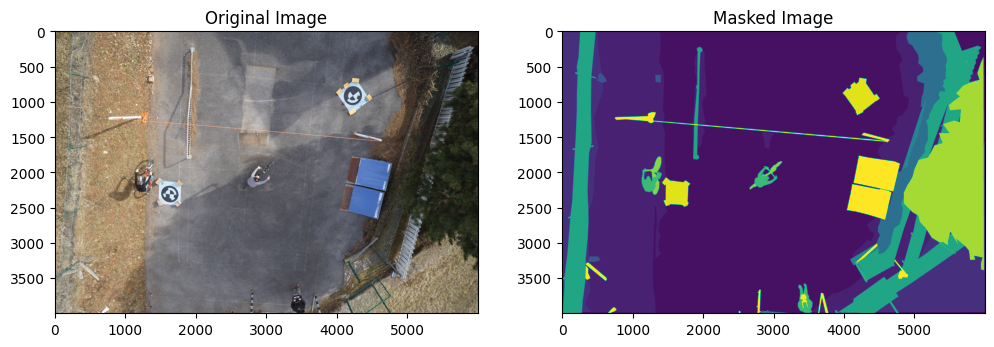

In [20]:
idx = 10
img = imageio.imread(image_list[idx])
print(img.shape)

mask = imageio.imread(mask_list[idx])

print(mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(12, 10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

In [23]:
df = create_image_id_dataframe(img_path)

X_train_and_val, X_test = train_test_split(
    df["id"].values, test_size=0.1, random_state=19
)
X_train, X_val = train_test_split(X_train_and_val, test_size=0.15, random_state=19)

print("Train Size ", len(X_train))
print("Test Size ", len(X_test))
print("Val Size ", len(X_val))

t_train = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_val = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

train_dataset = DataGenerator(
    img_path,
    mask_path,
    X_train,
    mean,
    std,
    transform=t_train,
    normalize=True,
    patch=use_patch,
)
val_dataset = DataGenerator(
    img_path, mask_path, X_val, transform=t_val, normalize=True, patch=use_patch
)
test_dataset = DataGenerator(img_path, mask_path, X_test, transform=t_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Size  107
Test Size  15
Val Size  20


In [24]:
model = SegmentationModel(num_classes)

# model = torch.load("/kaggle/working/deeplabv3_resnet50.pt")

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

In [12]:
history = train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, device, patch=use_patch)
torch.save(model, save_path)
print(f"Saved {save_path}")

  0%|          | 0/36 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 1.96 GiB of which 21.56 MiB is free. Including non-PyTorch memory, this process has 1.93 GiB memory in use. Of the allocated memory 1.87 GiB is allocated by PyTorch, and 24.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
plot_loss_vs_epoch(history)
plot_iou_score_vs_epoch(history)
plot_accuracy_vs_epoch(history)

NameError: name 'history' is not defined

In [30]:
# Check if model file exists
load_path = f"DeepLabV3_ResNet50.pt"
if os.path.exists(load_path):
    # Load the model
    model = torch.load(load_path)
    print(f"Loaded {save_path}")

Loaded DeepLabV3_ResNet50.pt


  0%|          | 0/15 [00:00<?, ?it/s]

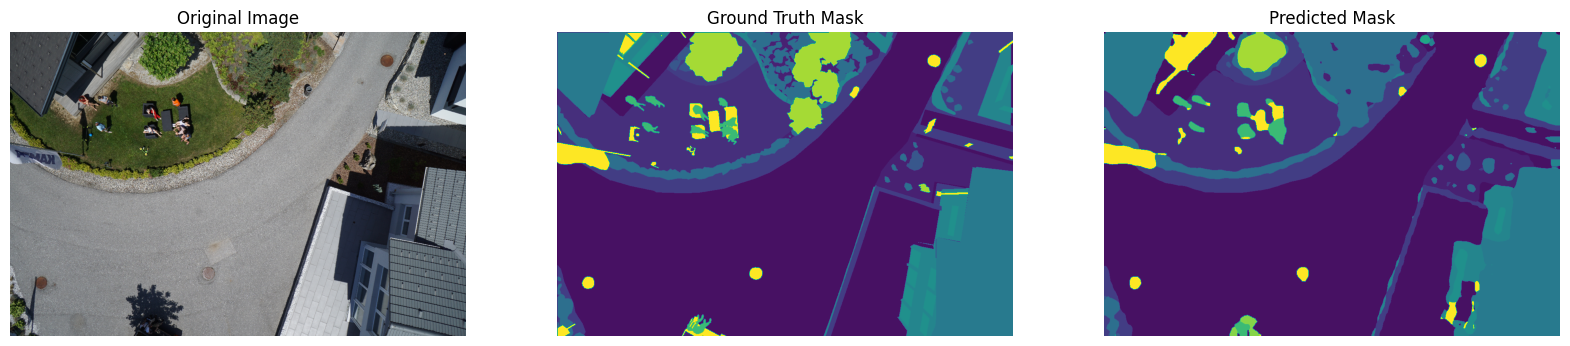

In [31]:
image, mask = test_dataset[3]

pred_mask, miou, acc = predict_image_mask_miou_pixel_accuracy(model, image, mask, device)
test_set_miou, test_set_accuracy = get_miou_pixel_accuracy_scores_from_trained_model(model, test_dataset, device)

visualize_image_mask(image, mask, pred_mask)